TESTING....

In [1]:
from sklearn.linear_model import Ridge, RidgeCV, LassoCV, Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import pandas as pd

from statsmodels.tools.tools import pinv_extended
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
import sklearn, statsmodels

In [2]:
df_temp = pd.read_csv("./airbnb_attractions.csv")
missing_values_per_column = df_temp.isnull().sum()
print(missing_values_per_column)

id                                  0
last_scraped                        0
neighbourhood                    8050
neighbourhood_cleansed              0
neighbourhood_group_cleansed    19764
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                       22305
bathrooms_text                      6
bedrooms                        22301
beds                              408
price                            2088
has_availability                 2088
availability_30                     0
availability_60                     0
availability_90                     0
availability_365                    0
number_of_reviews                   0
number_of_reviews_ltm               0
number_of_reviews_l30d              0
review_scores_rating                0
review_scores_accuracy              1
review_scores_cleanliness           1
review_score

<ipython-input-2-75c0597a9376>:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv("./airbnb_attractions.csv")


In [3]:
# Extract numeric value from 'bathrooms_text' and handle special cases
def extract_bathrooms(text):
    if pd.isnull(text):
        return np.nan
    if 'half-bath' in text.lower():
        return 0.5
    numbers = pd.to_numeric(pd.Series(text).str.extract('(\d+\.?\d*)')[0], errors='coerce')
    if numbers.empty:
        return np.nan
    return numbers.iloc[0]

In [4]:
def process_data():
    """All code below are borrowed from Peter's"""
    # remove has availability + empty price (since these can't help us)
    # remove empty review records since not so many
    # remove columns bedrooms, bathrooms
    # remove neighbourhood_group_cleansed
    df = pd.read_csv("./airbnb_attractions2.csv")

    df = df.dropna(subset=['has_availability', 'price'])

    review_columns = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
                      'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
                      'review_scores_value']
    df = df.dropna(subset=review_columns)

    df = df.drop(columns=['bedrooms', 'bathrooms', 'neighbourhood_group_cleansed', 'neighbourhood'])

    df = df.dropna(subset=['bathrooms_text', 'beds'])


    # 1. drop column last_scraped, # drop property_type, neighbourhood_cleansed
    df = df.drop(columns=['last_scraped', 'neighbourhood_cleansed'])

    # 2. One-hot encode 'room_type'
    property_types = list(df_temp["property_type"].value_counts().index)[:37]
    df['property_type'] = [i if i in property_types else "Other" for i in df['property_type']]
    df = pd.get_dummies(df, columns=['property_type', 'room_type'], drop_first=False)

    # 3. Process 'bathrooms_text'
    # Create shared_bathroom indicator
    df['shared_bathroom'] = df['bathrooms_text'].str.contains('shared').astype(int)

    # Apply the corrected function
    df['bathrooms'] = df['bathrooms_text'].apply(extract_bathrooms)

    # Ensure we handle any potential issues with NaN values correctly
    df['bathrooms'] = pd.to_numeric(df['bathrooms'], errors='coerce')

    # Continue with the rest of your preprocessing
    df = df.drop(columns=['bathrooms_text'])

    # 4. Convert 'has_availability'
    df['has_availability'] = df['has_availability'].map({'t': 1, 'f': 0})

    # 5. Encode 'city' with numeric identifiers (e.g., Toronto=1, Sydney=2, Barcelona=3)
    city_mapping = {'Toronto': 1, 'Sydney': 2, 'Barcelona': 3}
    df['city_id'] = df['city'].map(city_mapping)
    # print(df.head())



    # THE FOLLOWING BELOW IS ADAPTED FROM PETER'S CODE

    df = df.drop(columns=['city'])
    df['price'] = df['price'].str.replace('[^0-9.]', '', regex=True).astype('float64')
    return df


In [5]:
def run_lasso(df, predictors, target='price', normalize=False, dataset_name='Dataset'):
    # BORROWED FROM PETER'S CODE
    # Check for missing columns
    missing_columns = [col for col in predictors + [target] if col not in df.columns]
    if missing_columns:
        raise ValueError(f"The following columns are missing from the DataFrame: {missing_columns}")

    # Prepare predictors and target variables
    X = df[predictors]
    y = df[target]
    X_cols = X.columns
    X_index = X.index

    # Impute data because we have missing values here aaaaa so that it can work SKLEARN's REGRESSION
    imputer = KNNImputer(weights="uniform") # Maybe go distance for each weight???
    # Might have to extract price here for supervised imputation? But...wouldn't that cause bias in the regression?
    X = pd.DataFrame(data=imputer.fit_transform(X=X), columns=X_cols, index=X_index)

    print(X.describe())
    print(np.exp(y).describe())

    # Normalize features column-wise.
    if normalize:
        scaler = StandardScaler()
        X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

    # Split into train and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)
    # Fit the LASSO regression.
    lasso_CV = LassoCV(cv=10, random_state=0) # Lasso with cross-validation at each alpha hyperparameter!
    lasso_CV.fit(X_train, y_train)

    print(f"Best alpha value: {lasso_CV.alpha_}")
    lasso_best = Lasso(alpha=lasso_CV.alpha_)
    lasso_best.fit(X_train, y_train)

    # # Print results
    print("\nSignificant predictors and their coefficients:")
    coeff_col = list(zip(lasso_best.coef_, X))
    for (coeffs, col) in coeff_col:
        print(f"{col}: {coeffs}")
    print(f"R squared training set: {round(lasso_best.score(X_train, y_train), 2)}")
    print(f"R squared test set: {round(lasso_best.score(X_test, y_test), 2)}")
    print(f"Test MSE: {mean_squared_error(y_test, lasso_best.predict(X_test))}")

    # Draw the MSE error at each alpha alongside the average MSE of all fold at a particular alpha.
    fig, ax = plt.subplots()
    ax.semilogx(lasso_CV.alphas_, lasso_CV.mse_path_, ":")
    ax.plot(
        lasso_CV.alphas_ ,
        lasso_CV.mse_path_.mean(axis=-1),
        "k",
        label="Average across the folds",
        linewidth=2,
    )
    ax.axvline(
        lasso_CV.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
    )

    ax.legend()
    ax.set_xlabel("alphas")
    ax.set_ylabel("Mean square error")
    ax.set_title("Mean square error on each fold")
    ax.axis("tight")

    ymin, ymax = 5000, 150000
    ax.set_ylim(ymin, ymax);

    fig, ax = plt.subplots()
    alphas = np.linspace(0.01,500,100)
    lasso = Lasso(max_iter=10000)
    coefs = []

    # Plot trace of coefficients of each column
    for a in alphas:
        lasso.set_params(alpha=a)
        lasso.fit(X_train, y_train)
        coefs.append(lasso.coef_)

    ax = plt.gca()
    ax.axvline(
        lasso_CV.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
    )
    ax.plot(alphas, coefs)
    ax.set_xscale('log')
    ax.axis('tight')
    ax.legend()
    ax.set_xlabel('alpha')
    ax.set_ylabel('Standardized Coefficients')
    ax.set_title('Lasso coefficients as a function of alpha');

    # Plots for comparing the prices with the LASSO-predicted one.
    fig, ax = plt.subplots(1, figsize=(15, 5))
    predicted = lasso_best.predict(X)
    # draw sth here....
    num_listing = [i for i in range(0, y.shape[0])]
    ax.plot(num_listing, y, label="Original Price")
    ax.plot(num_listing, predicted, label="Predicted Price")
    ax.set_title("Original price vs predicted price")
    ax.set_xlabel("Listing No.")
    ax.set_ylabel("Price")
    ax.legend()
    plt.show()

    # t-test
    # https://stackoverflow.com/questions/40072870/statistical-summary-table-in-sklearn-linear-model-ridge
    X_train = sm.add_constant(X_train)  # add constant term for intercept
    model = sm.OLS(y_train, X_train)
    results = model.fit()#_regularized(alpha=lasso_CV.alpha_)
    print(results.summary())
    # model_params = results.params

    # pinv_wexog,_ = pinv_extended(X_train)
    # normalized_cov_params = np.dot(pinv_wexog, np.transpose(pinv_wexog))
    # lin_reg = sm.regression.linear_model.OLSResults(model, model_params, normalized_cov_params)

    # print(lin_reg.summary())

    # ANOVA
    # Make sure to include the variables for location in X_train
    X_train2 = X_train.drop(["distance_to_attraction", "distance_to_largest"], axis=1)
    model2 = sm.OLS(y_train, X_train2).fit()
    anova_results = anova_lm(model2, results)
    print(anova_results)

    return

In [6]:
# Borrowed from Peter's. THIS IS TO MAINTAIN CONSISTENCY!!!
# wait, why would we need id for? isn't it just for database stuff?
# same goes for city_id too considering we have the longitude and latitude I think...
# Anyways, we have to experiment which column to include...
# objective_columns = [
#     "id", , 'accommodates', 'beds',
#     'has_availability', 'availability_30', 'availability_60', 'availability_90',
#     'availability_365', 'distance_to_attraction',
#     'room_type_Entire home/apt', 'room_type_Hotel room',
#     'room_type_Private room', 'room_type_Shared room',
#     'shared_bathroom', 'bathrooms', "city_id"]
objective_columns = [
 'accommodates',
 'beds',
 'has_availability',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365',
#  'distance_to_attraction',
 'room_type_Entire home/apt',
 'room_type_Hotel room',
 'room_type_Private room',
 'room_type_Shared room',
 'shared_bathroom',
 'bathrooms',
#  'distance_to_largest',
 ]

objective_columns_loc = [
 'accommodates',
 'beds',
 'has_availability',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365',
 'distance_to_attraction',
 'room_type_Entire home/apt',
 'room_type_Hotel room',
 'room_type_Private room',
 'room_type_Shared room',
 'shared_bathroom',
 'bathrooms',
 'distance_to_largest',
]


all_columns = ['id', 'latitude', 'longitude', 'accommodates', 'beds',
               'has_availability', 'availability_30', 'availability_60', 'availability_90',
               'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
               'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
               'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month',
               'mean_sentiment', 'distance_to_attraction', 'attraction_reviews', 'room_type_Entire home/apt', 'room_type_Hotel room',
               'room_type_Private room', 'room_type_Shared room', 'shared_bathroom', 'bathrooms', 'city_id']

In [7]:
df = process_data()

# Split into 6 datasets: by city: Toronto, Barcelona, Sydney – objective and all columns
# Columns for the 'objective' dataset
df_toronto_all = df[df['city_id'] == 1]
print("Toronto df done")
df_sydney_all = df[df['city_id'] == 2]
print("Sydney df done")
df_barcelona_all = df[df['city_id'] == 3]
print("Barcelona df done")
all_columns = df.drop(['price'], axis=1).columns.tolist()  # Exclude 'price' from predictors

<ipython-input-4-9c61f5d1961e>:7: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./airbnb_attractions2.csv")


Toronto df done
Sydney df done
Barcelona df done


In [8]:
# outlier_threshold_tor = df_toronto_all["price"].mean() + 3 * df_toronto_all["price"].std()
# outlier_threshold_syd = df_sydney_all["price"].mean() + 3 * df_sydney_all["price"].std()
# outlier_threshold_bar = df_barcelona_all["price"].mean() + 3 * df_barcelona_all["price"].std()

# df_toronto_all = df_toronto_all[df_toronto_all["price"] <= outlier_threshold_tor]
# df_sydney_all = df_sydney_all[df_sydney_all["price"] <= outlier_threshold_syd]
# df_barcelona_all = df_barcelona_all[df_barcelona_all["price"] <= outlier_threshold_bar]

df_toronto_all.loc[:,"price"] = np.log(df_toronto_all["price"])
df_sydney_all.loc[:,"price"] = np.log(df_sydney_all["price"])
df_barcelona_all.loc[:,"price"] = np.log(df_barcelona_all["price"])

       accommodates          beds  has_availability  availability_30  \
count  10220.000000  10220.000000      10220.000000     10220.000000   
mean       3.253327      1.800881          0.998826        15.532387   
std        2.083330      1.116547          0.034248        12.559939   
min        1.000000      1.000000          0.000000         0.000000   
25%        2.000000      1.000000          1.000000         0.000000   
50%        2.000000      1.000000          1.000000        17.000000   
75%        4.000000      2.000000          1.000000        29.000000   
max       16.000000     11.000000          1.000000        30.000000   

       availability_60  availability_90  availability_365  \
count     10220.000000     10220.000000      10220.000000   
mean         34.368493        54.153620        171.830822   
std          23.753695        34.581466        124.039450   
min           0.000000         0.000000          0.000000   
25%           7.000000        21.000000       

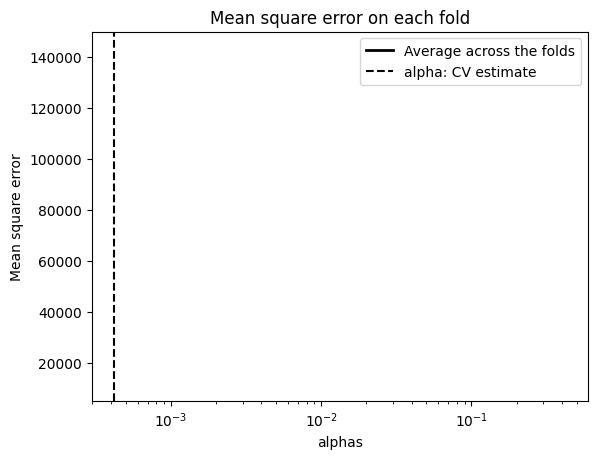

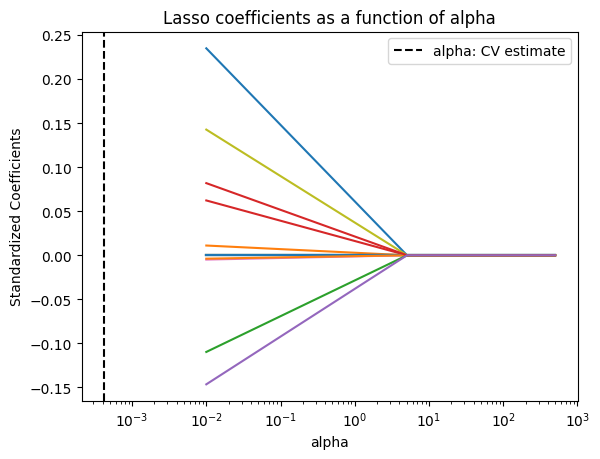

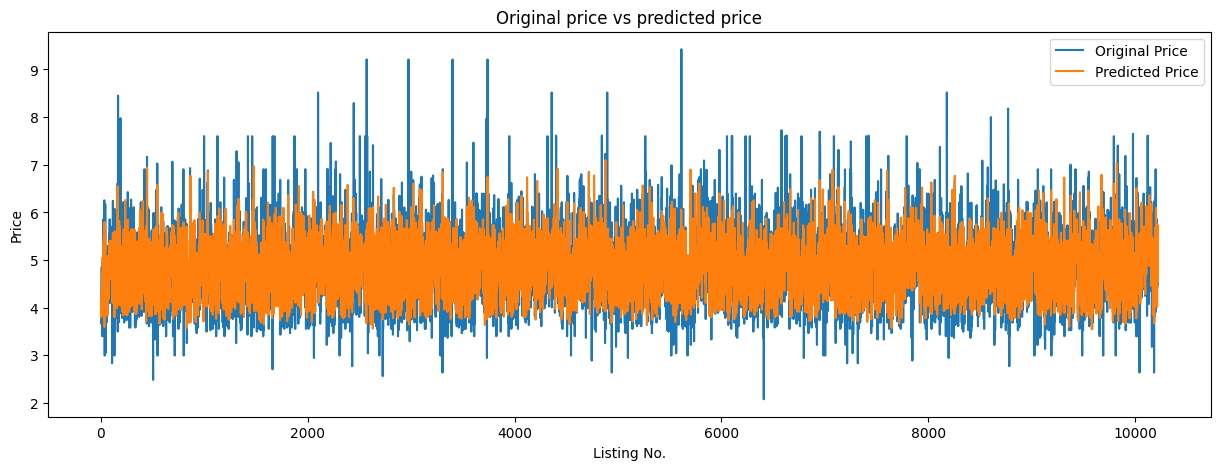

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.522
Model:                            OLS   Adj. R-squared:                  0.521
Method:                 Least Squares   F-statistic:                     686.3
Date:                Mon, 22 Apr 2024   Prob (F-statistic):               0.00
Time:                        16:14:42   Log-Likelihood:                -5887.6
No. Observations:                8176   AIC:                         1.180e+04
Df Residuals:                    8162   BIC:                         1.190e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [9]:
# Example calls for each dataset with 'all' columns. Again, borrowed from Peter's and modified accordingly.
# run_lasso(df_toronto_all, all_columns, normalize=True, dataset_name='Toronto All')
# run_lasso(df_sydney_all, all_columns, normalize=True, dataset_name='Sydney All')
# run_lasso(df_barcelona_all, all_columns, normalize=True, dataset_name='Barcelona All')

# I think the absurd cross-fold mse errors are due to some of the airbnb listings being way more expensive than others....

# Assuming 'objective_columns' is defined elsewhere and excludes 'price'
run_lasso(df_toronto_all, objective_columns_loc, normalize=True, dataset_name='Toronto Objective')


       accommodates         beds  has_availability  availability_30  \
count   7482.000000  7482.000000       7482.000000      7482.000000   
mean       3.581395     2.083400          0.660385         7.029404   
std        2.223477     1.495167          0.473610         9.710469   
min        1.000000     1.000000          0.000000         0.000000   
25%        2.000000     1.000000          0.000000         0.000000   
50%        3.000000     2.000000          1.000000         0.000000   
75%        4.000000     3.000000          1.000000        12.000000   
max       16.000000    27.000000          1.000000        30.000000   

       availability_60  availability_90  availability_365  \
count      7482.000000      7482.000000       7482.000000   
mean         17.071906        26.847100         99.542636   
std          21.024722        32.087834        124.137523   
min           0.000000         0.000000          0.000000   
25%           0.000000         0.000000          0.0000

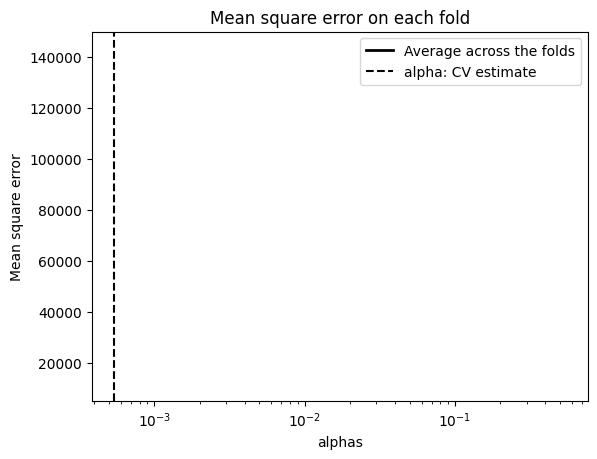

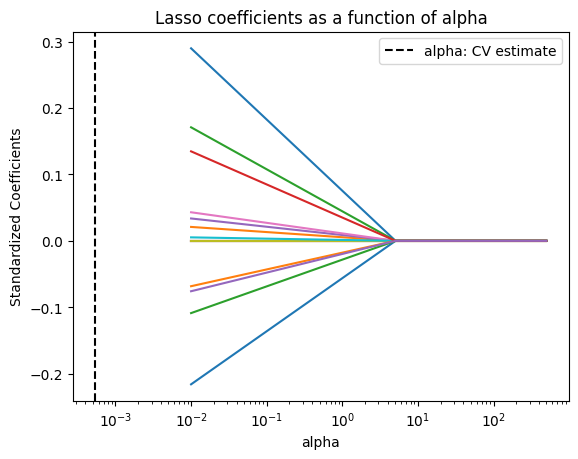

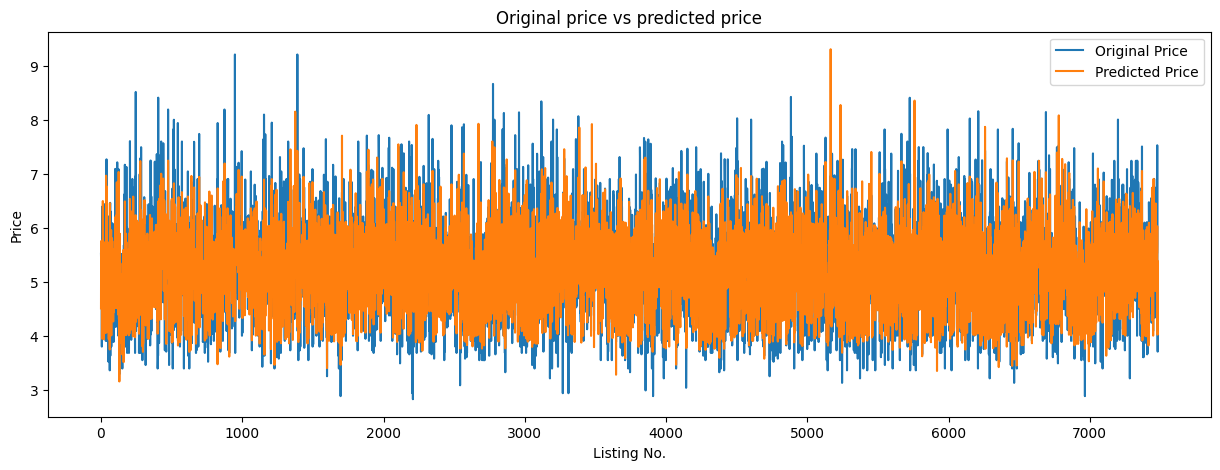

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.623
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                     703.8
Date:                Mon, 22 Apr 2024   Prob (F-statistic):               0.00
Time:                        02:00:10   Log-Likelihood:                -4649.6
No. Observations:                5985   AIC:                             9329.
Df Residuals:                    5970   BIC:                             9430.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [15]:
run_lasso(df_sydney_all, objective_columns_loc, normalize=True, dataset_name='Sydney Objective')


       accommodates         beds  has_availability  availability_30  \
count   2124.000000  2124.000000       2124.000000      2124.000000   
mean       3.731638     2.641714          0.992938        11.838512   
std        2.198899     1.890844          0.083759        10.292876   
min        1.000000     1.000000          0.000000         0.000000   
25%        2.000000     1.000000          1.000000         0.000000   
50%        4.000000     2.000000          1.000000        11.000000   
75%        5.000000     4.000000          1.000000        20.000000   
max       16.000000    20.000000          1.000000        30.000000   

       availability_60  availability_90  availability_365  \
count      2124.000000      2124.000000       2124.000000   
mean         27.548493        44.237759        190.396893   
std          21.006784        31.850695        129.751827   
min           0.000000         0.000000          0.000000   
25%           5.000000        11.000000         67.0000

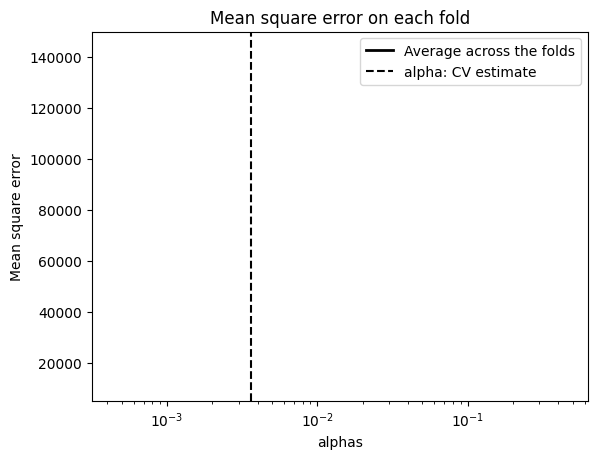

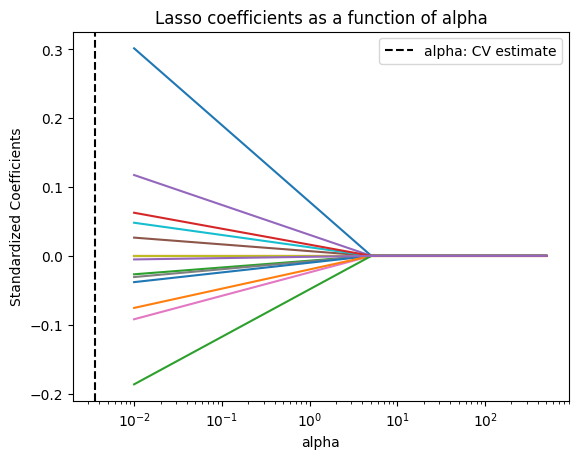

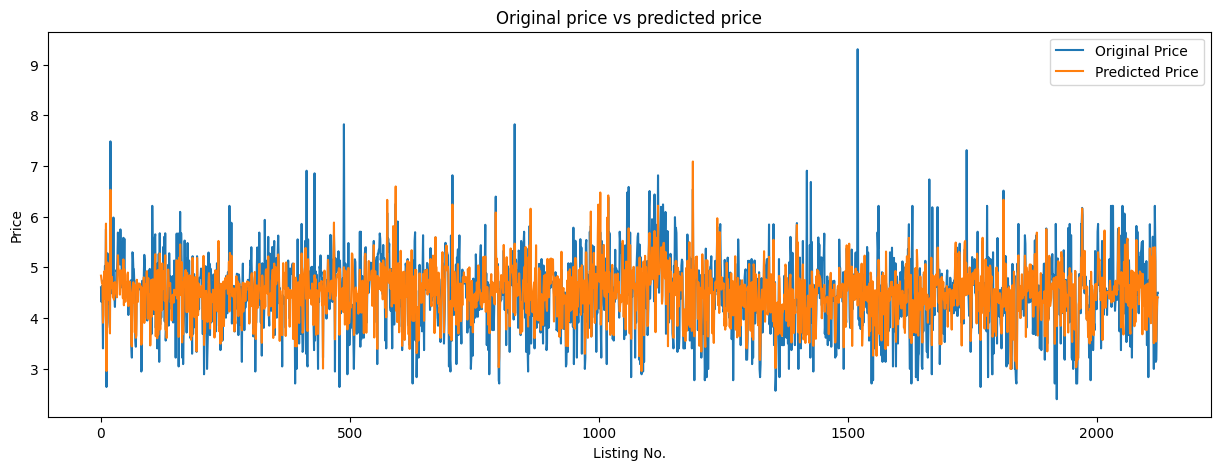

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.491
Model:                            OLS   Adj. R-squared:                  0.487
Method:                 Least Squares   F-statistic:                     116.2
Date:                Mon, 22 Apr 2024   Prob (F-statistic):          4.04e-235
Time:                        02:00:13   Log-Likelihood:                -1321.5
No. Observations:                1699   AIC:                             2673.
Df Residuals:                    1684   BIC:                             2755.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [16]:
run_lasso(df_barcelona_all, objective_columns_loc, normalize=True, dataset_name='Barcelona Objective')

Ridge Regression

In [16]:
def run_ridge(df, predictors, target='price', normalize=False, dataset_name='Dataset'):
    # BORROWED FROM PETER'S CODE
    # Check for missing columns
    missing_columns = [col for col in predictors + [target] if col not in df.columns]
    if missing_columns:
        raise ValueError(f"The following columns are missing from the DataFrame: {missing_columns}")

    # Prepare predictors and target variables
    X = df[predictors]
    y = df[target]
    X_cols = X.columns
    X_index = X.index

    # Impute data because we have missing values here aaaaa so that it can work SKLEARN's REGRESSION
    imputer = KNNImputer(weights="uniform") # Maybe go distance for each weight???
    # Might have to extract price here for supervised imputation? But...wouldn't that cause bias in the regression?
    X = pd.DataFrame(data=imputer.fit_transform(X=X), columns=X_cols, index=X_index)

    # Normalize features column-wise.
    if normalize:
        scaler = StandardScaler()
        X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

    # Split into train and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)
    # Fit the ridge regression.
    alphas = np.linspace(0.01,1000,100)
    ridge_CV = RidgeCV(alphas=alphas, cv=10) # Lasso with cross-validation at each alpha hyperparameter!
    ridge_CV.fit(X_train, y_train)

    print(f"Best alpha value: {ridge_CV.alpha_}")
    ridge_best = Ridge(alpha=ridge_CV.alpha_)
    ridge_best.fit(X_train, y_train)

    # # Print results
    print("\nSignificant predictors and their coefficients:")
    coeff_col = list(zip(ridge_best.coef_, X))
    for (coeffs, col) in coeff_col:
        print(f"{col}: {coeffs}")
    print(f"R squared training set: {round(ridge_best.score(X_train, y_train), 2)}")
    print(f"R squared test set: {round(ridge_best.score(X_test, y_test), 2)}")
    print(f"Test MSE: {mean_squared_error(y_test, ridge_best.predict(X_test))}")
    print(f"Test MSE (exp): {mean_squared_error(np.exp(y_test), np.exp(ridge_best.predict(X_test)))}")

    # Plots for comparing the prices with the Ridge-predicted one.
    fig, ax = plt.subplots(1, figsize=(15, 5))
    predicted = ridge_best.predict(X)
    # draw sth here....
    num_listing = [i for i in range(0, y.shape[0])]
    ax.plot(num_listing, y, label="Original Price")
    ax.plot(num_listing, predicted, label="Predicted Price")
    ax.set_title("Original price vs predicted price")
    ax.set_xlabel("Listing No.")
    ax.set_ylabel("Price")
    ax.legend()
    plt.show()

    # X_train = sm.add_constant(X_train)  # add constant term for intercept
    # model = sm.OLS(y_train, X_train)
    # results = model.fit_regularized(alpha=ridge_CV.alpha_, L1_wt = 0)
    # model_params = results.params

    # pinv_wexog,_ = pinv_extended(X_train)
    # normalized_cov_params = np.dot(pinv_wexog, np.transpose(pinv_wexog))
    # lin_reg = sm.regression.linear_model.OLSResults(model, model_params, normalized_cov_params)

    # print(lin_reg.summary())

    residuals = predicted - y
    plt.scatter(df["longitude"], df["latitude"], c=residuals, s=2)
    plt.show()

    # plt.scatter(predicted, residuals, s=2)

    plt.rcParams['axes.facecolor'] = 'black'
    plt.hexbin(df["longitude"], df["latitude"], C = abs(residuals), gridsize=25, vmin=0, vmax=2)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    # plt.title(f"Residuals by Location - {dataset_name}")
    plt.rcParams['axes.facecolor'] = 'white'
    # plt.show()
    plt.colorbar()
    plt.savefig(f"{dataset_name}_loc.png")
    plt.show()

    # import matplotlib.cm as cm
    # from scipy.ndimage import gaussian_filter

    # def myplot(x, y, s, bins=1000):
    #     heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
    #     heatmap = gaussian_filter(heatmap, sigma=s)

    #     extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    #     return heatmap.T, extent

    # img, extent = myplot(df["longitude"], df["latitude"], 16)
    # plt.imshow(img, extent=extent, origin='lower', cmap=cm.jet)

    # import seaborn as sns

    # sns.kdeplot(x=df["longitude"], y=df["latitude"], fill = True, warn_singular=False)

    return residuals

Best alpha value: 20.211818181818185

Significant predictors and their coefficients:
accommodates: 0.22746112884888917
beds: 0.004727709141523724
has_availability: 0.003241581993140693
availability_30: 0.1500074448407455
availability_60: -0.09824361654545456
availability_90: 0.019297375262522204
availability_365: -0.030210298581228354
room_type_Entire home/apt: 0.10290885158763877
room_type_Hotel room: 0.0
room_type_Private room: -0.10012404938507688
room_type_Shared room: -0.0197500063198863
shared_bathroom: -0.12266146955729629
bathrooms: 0.08647415088030239
R squared training set: 0.48
R squared test set: 0.52
Test MSE: 0.27143528479615125
Test MSE (exp): 94496.1445588615


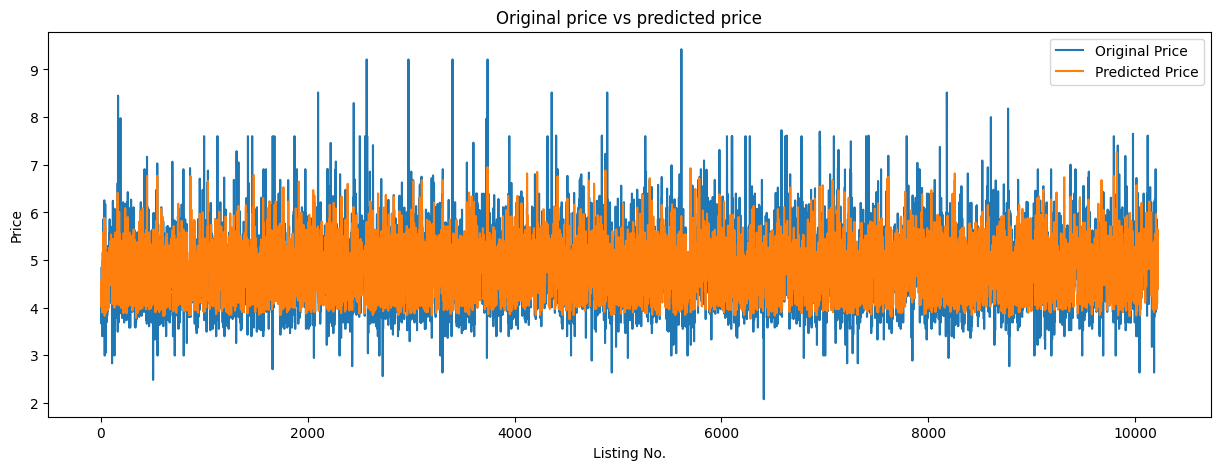

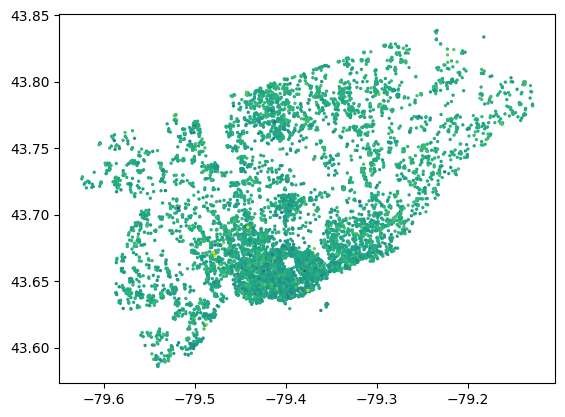

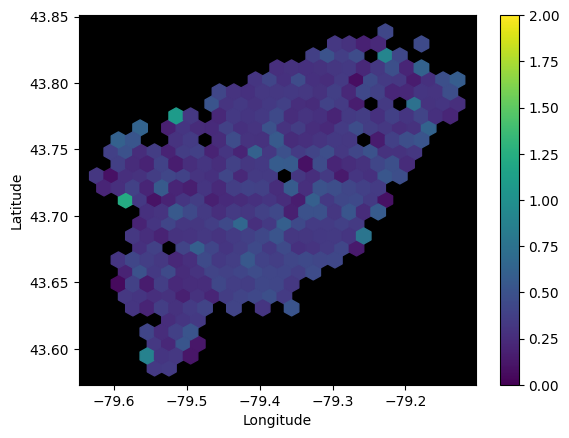

In [22]:
res_toronto = run_ridge(df_toronto_all, objective_columns, normalize=True, dataset_name='Toronto')

In [ ]:
res_toronto_loc = run_ridge(df_toronto_all, objective_columns_loc, normalize=True, dataset_name='Toronto')

Best alpha value: 10.110909090909091

Significant predictors and their coefficients:
accommodates: 0.2722706056299372
beds: 0.01859082545847979
has_availability: 0.1726645833989463
availability_30: -0.019855763970181677
availability_60: 0.1887824836369885
availability_90: -0.14948803769935706
availability_365: 0.051680197971519334
room_type_Entire home/apt: 0.113925572773228
room_type_Hotel room: 0.04635767770832739
room_type_Private room: -0.11786515797078125
room_type_Shared room: -0.055852781942583606
shared_bathroom: -0.11370362069431435
bathrooms: 0.14352327661951159
R squared training set: 0.61
R squared test set: 0.6
Test MSE: 0.27139533092940377
Test MSE (exp): 63453.59422238292


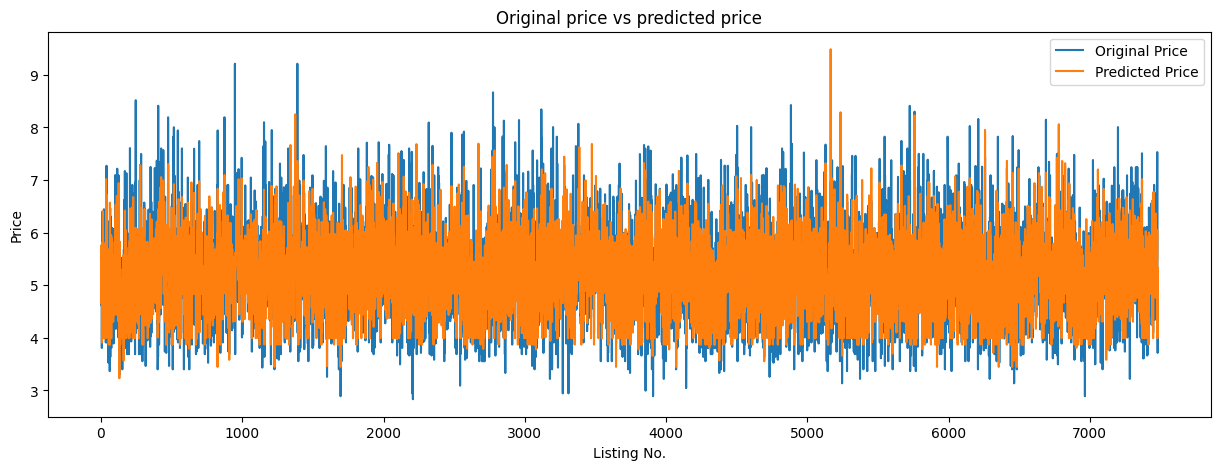

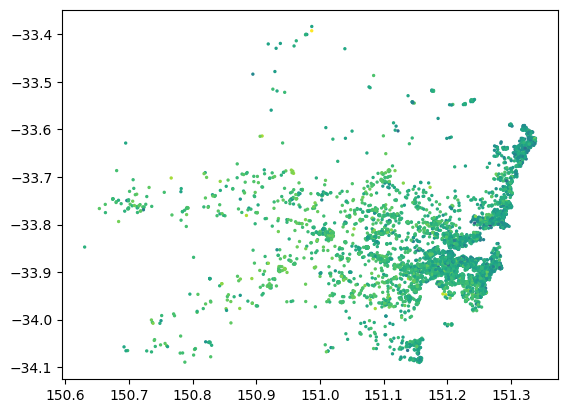

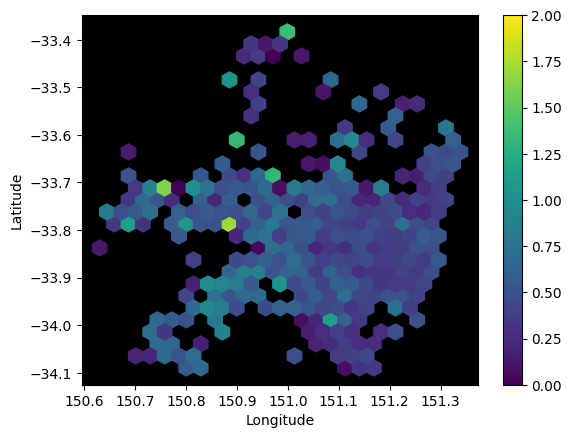

In [23]:
res_sydney = run_ridge(df_sydney_all, objective_columns, normalize=True, dataset_name='Sydney')


In [ ]:
res_sydney_loc = run_ridge(df_sydney_all, objective_columns_loc, normalize=True, dataset_name='Sydney')

Best alpha value: 20.211818181818185

Significant predictors and their coefficients:
accommodates: 0.29387553981658027
beds: 0.0009205348554176207
has_availability: -0.035709810734589315
availability_30: 0.005773367556726014
availability_60: 0.09165373142206917
availability_90: 0.0789562374704767
availability_365: -0.12332922218792898
room_type_Entire home/apt: 0.026461507560889275
room_type_Hotel room: 0.06682211835670739
room_type_Private room: -0.03330521942039563
room_type_Shared room: -0.08263040733728412
shared_bathroom: -0.18409250409300787
bathrooms: 0.07475650942544147
R squared training set: 0.49
R squared test set: 0.55
Test MSE: 0.23859665642658429
Test MSE (exp): 17064.58162207417


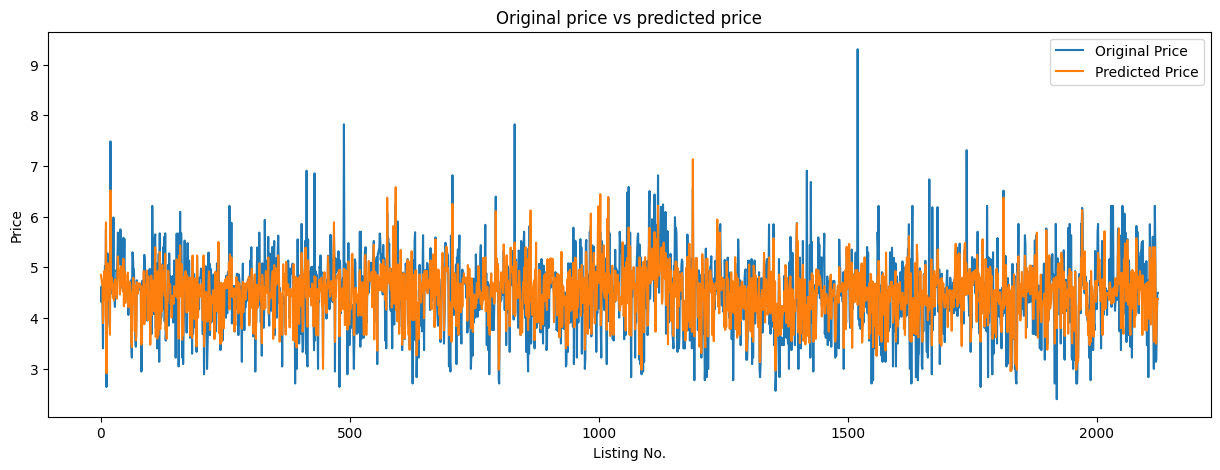

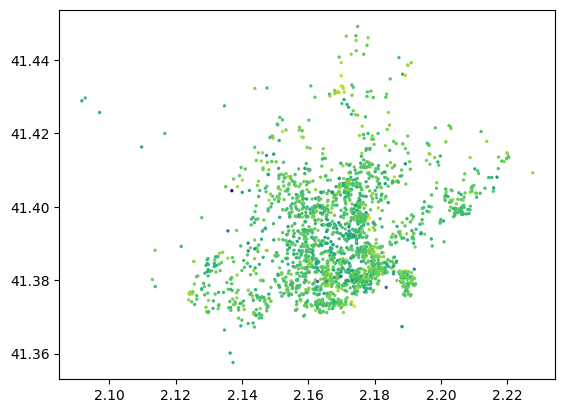

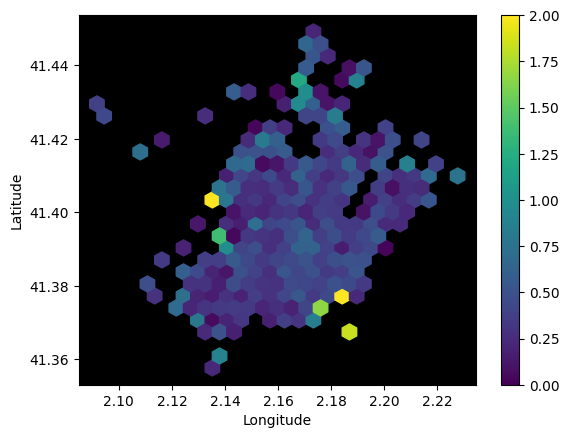

In [24]:
res_barcelona = run_ridge(df_barcelona_all, objective_columns, normalize=True, dataset_name='Barcelona')

In [ ]:
res_barcelona_loc = run_ridge(df_barcelona_all, objective_columns_loc, normalize=True, dataset_name='Barcelona')

In [43]:
def plot_res_diff(df, predictors, res, res_loc, dataset_name, target='price', normalize=True):
    # Prepare predictors and target variables
    X = df[predictors]
    y = df[target]
    X_cols = X.columns
    X_index = X.index

    # Impute data because we have missing values here aaaaa so that it can work SKLEARN's REGRESSION
    imputer = KNNImputer(weights="uniform") # Maybe go distance for each weight???
    # Might have to extract price here for supervised imputation? But...wouldn't that cause bias in the regression?
    X = pd.DataFrame(data=imputer.fit_transform(X=X), columns=X_cols, index=X_index)

    # Normalize features column-wise.
    if normalize:
        scaler = StandardScaler()
        X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

    # Split into train and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)

    res_diff = abs(res) - abs(res_loc)

    # plt.rcParams['axes.facecolor'] = 'black'
    plt.hexbin(df["longitude"], df["latitude"], C = res_diff, gridsize=25, vmin=-0.5, vmax=0.5)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    # plt.title(f"Residuals by Location - {dataset_name}")
    # plt.rcParams['axes.facecolor'] = 'white'
    # plt.show()
    plt.colorbar()
    plt.savefig(f"{dataset_name}_diff.png")
    plt.show()

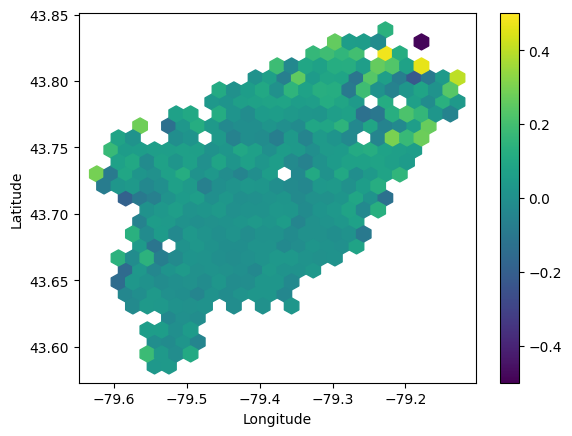

In [44]:
plot_res_diff(df_toronto_all, objective_columns, res_toronto, res_toronto_loc, "Toronto")

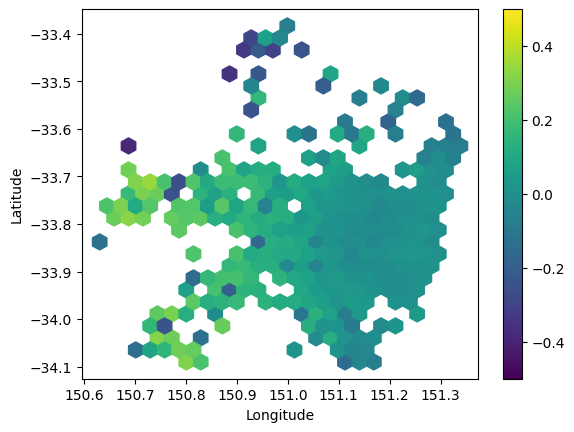

In [45]:
plot_res_diff(df_sydney_all, objective_columns, res_sydney, res_sydney_loc, "Sydney")

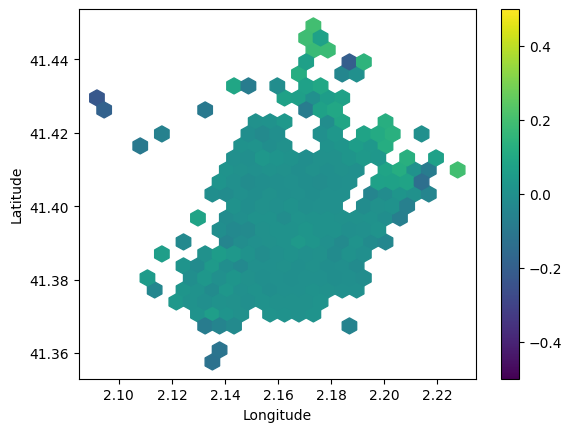

In [46]:
plot_res_diff(df_barcelona_all, objective_columns, res_barcelona, res_barcelona_loc, "Barcelona")